# 6장 사이파이 선형대수학

## 6.1 선형대수학 기초

In [1]:
import numpy as np

m, n = (5, 6)  # 스칼라
M = np.ones((m, n))  # 행렬
v = np.random.random((n,))  # 벡터
w = M @ v  # 다른 벡터

## 6.2 그래프의 라플라시안 행렬

### 6.2.1 연습문제 : 회전행렬

In [3]:
import numpy as np

A = np.array([[0, 1, 1, 0, 0, 0],
              [1, 0, 1, 0, 0, 0],
              [1, 1, 0, 1, 0, 0],
              [0, 0, 1, 0, 1, 1],
              [0, 0, 0, 1, 0, 1],
              [0, 0, 0, 1, 1, 0]], dtype=float)

In [14]:
# 그래프를 바로 표시하고, 사용자 정의 스타일을 적용한다.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

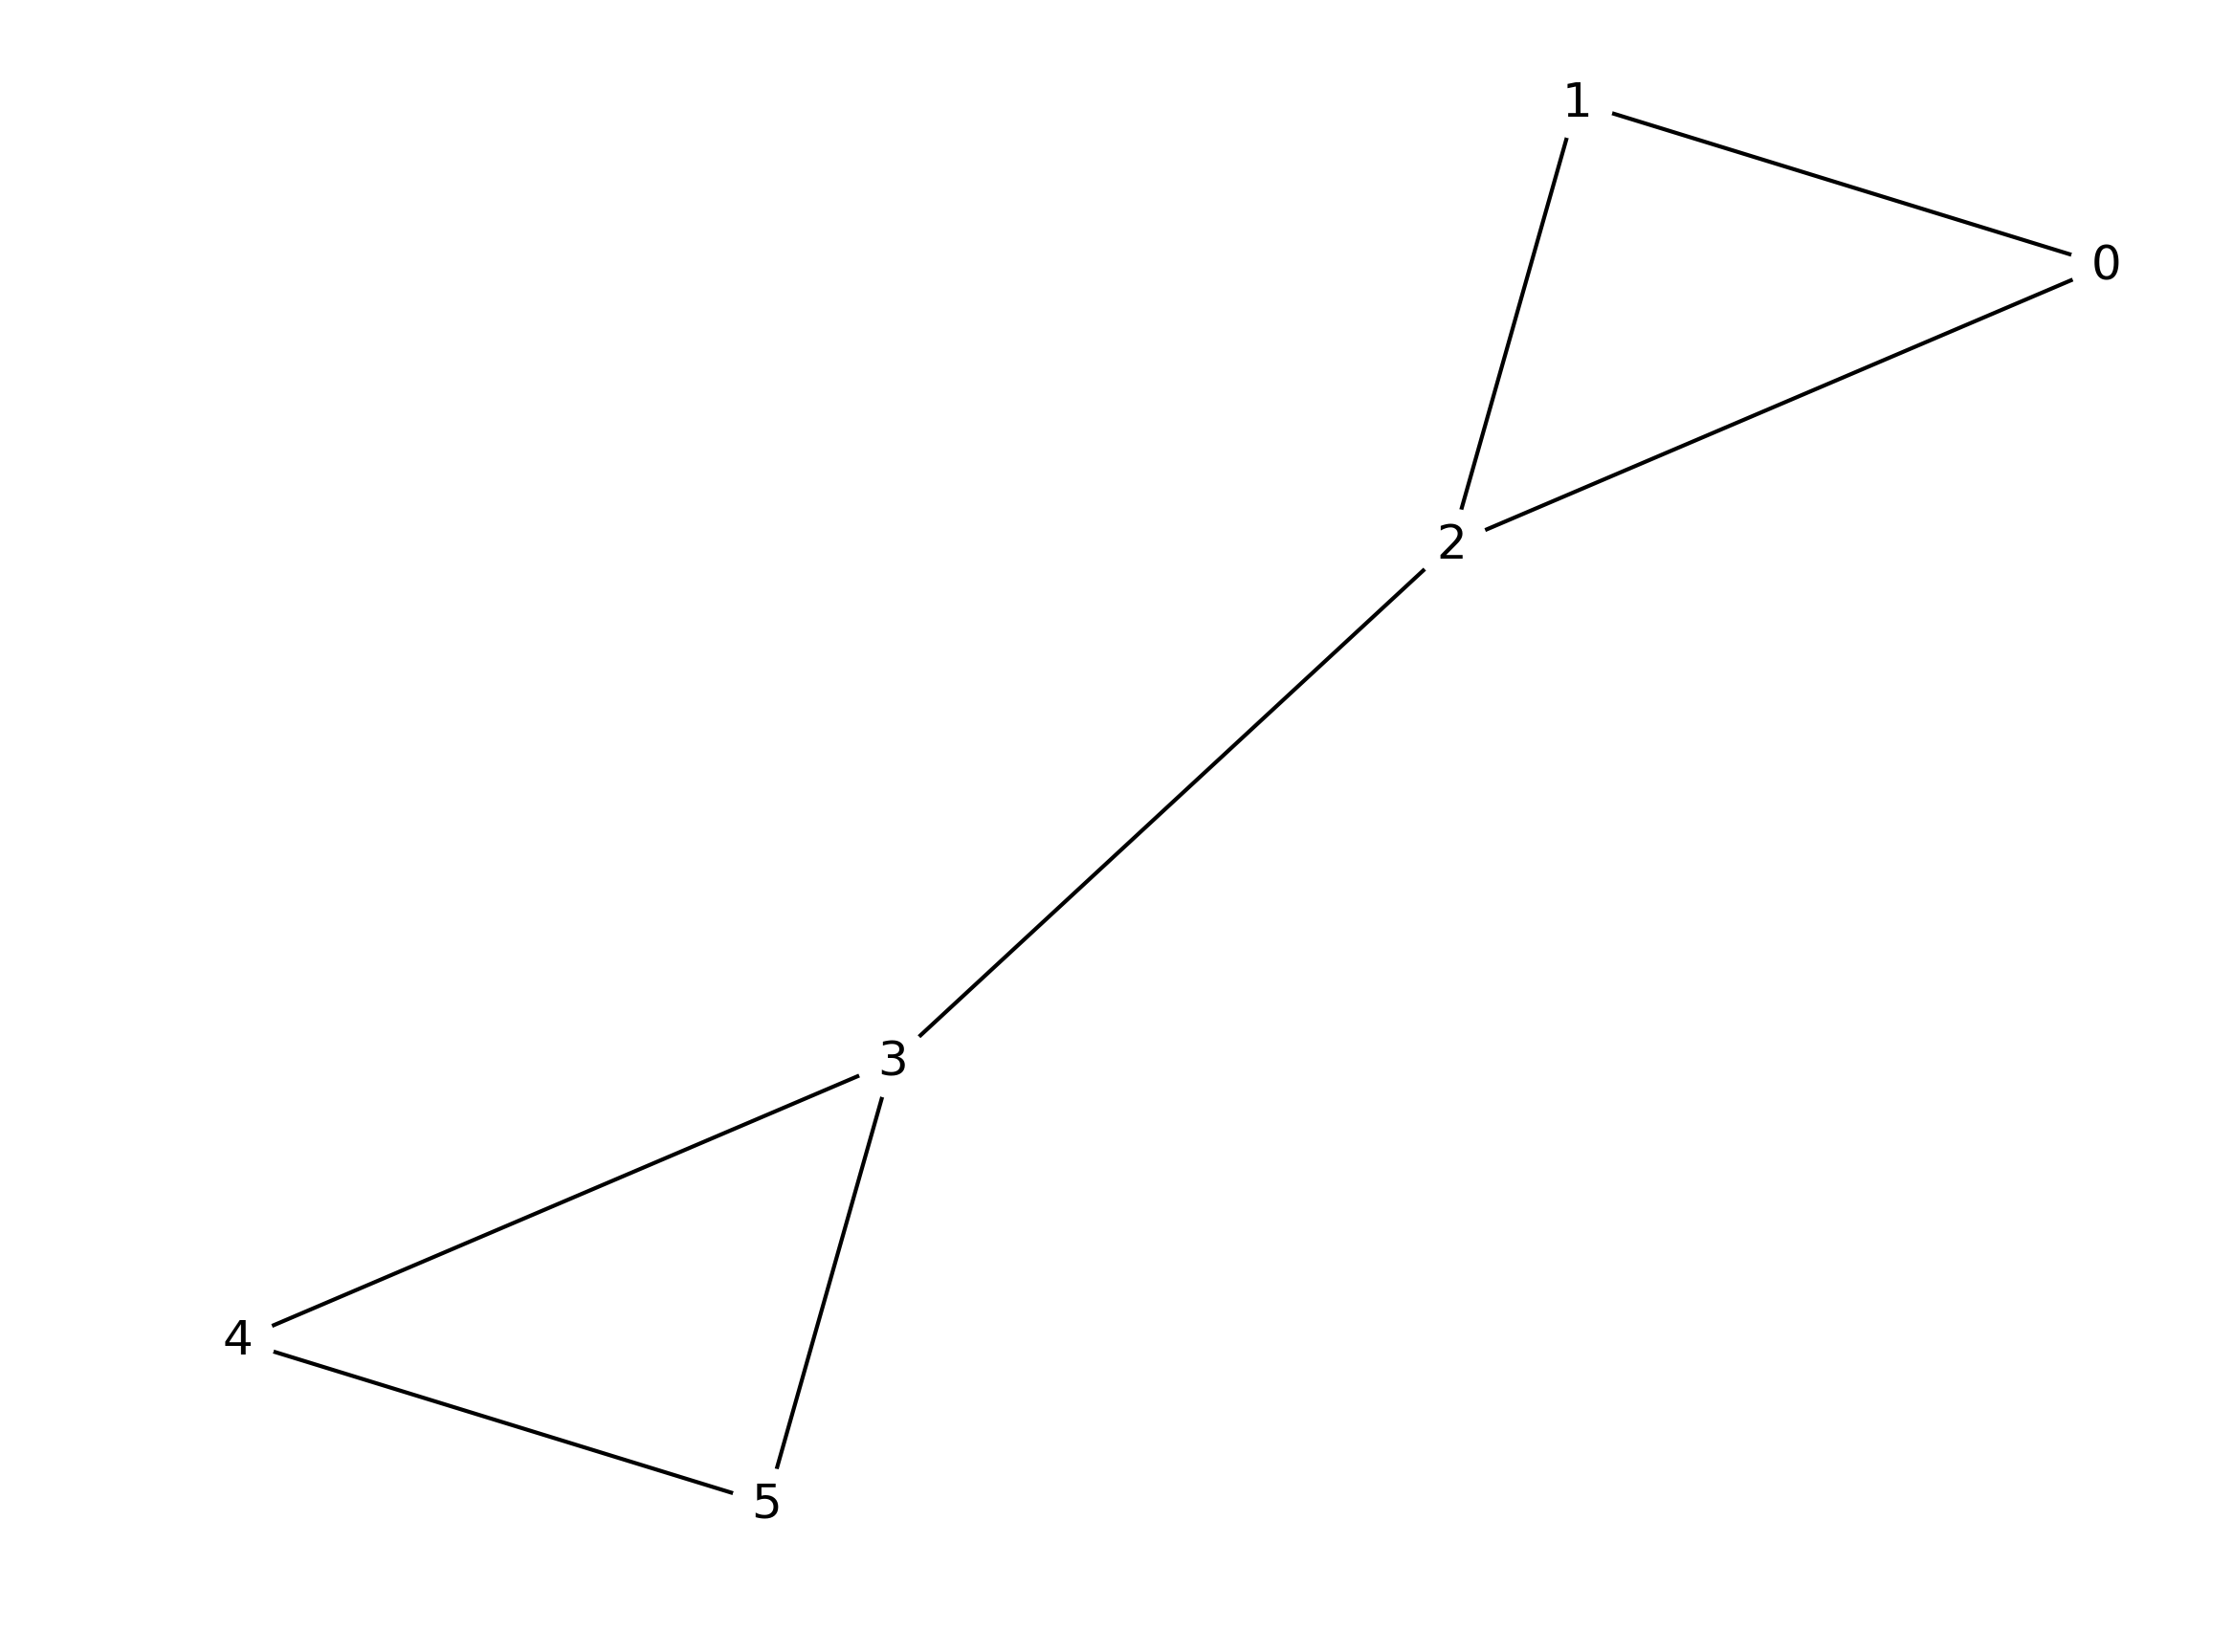

In [18]:
import networkx as nx

g = nx.from_numpy_matrix(A)
layout = nx.spring_layout(g, pos=nx.circular_layout(g))
nx.draw(g, pos=layout,
        with_labels=True, node_color='white')

In [6]:
d = np.sum(A, axis=0)
print(d)

[ 2.  2.  3.  3.  2.  2.]


In [7]:
D = np.diag(d)
print(D)

[[ 2.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  2.]]


In [8]:
L = D - A 
print(L)

[[ 2. -1. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [-1. -1.  3. -1.  0.  0.]
 [ 0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1. -1.  2.]]


In [9]:
val, Vec = np.linalg.eigh(L)

In [10]:
np.any(np.isclose(val, 3))

True

In [11]:
idx_lambda3 = np.argmin(np.abs(val - 3))
v3 = Vec[:, idx_lambda3]

print(v3)
print(L @ v3)

[ 0.76360255 -0.55068122 -0.21292133 -0.21292133  0.09376005  0.11916128]
[ 2.29080765 -1.65204367 -0.63876398 -0.63876398  0.28128015  0.35748383]


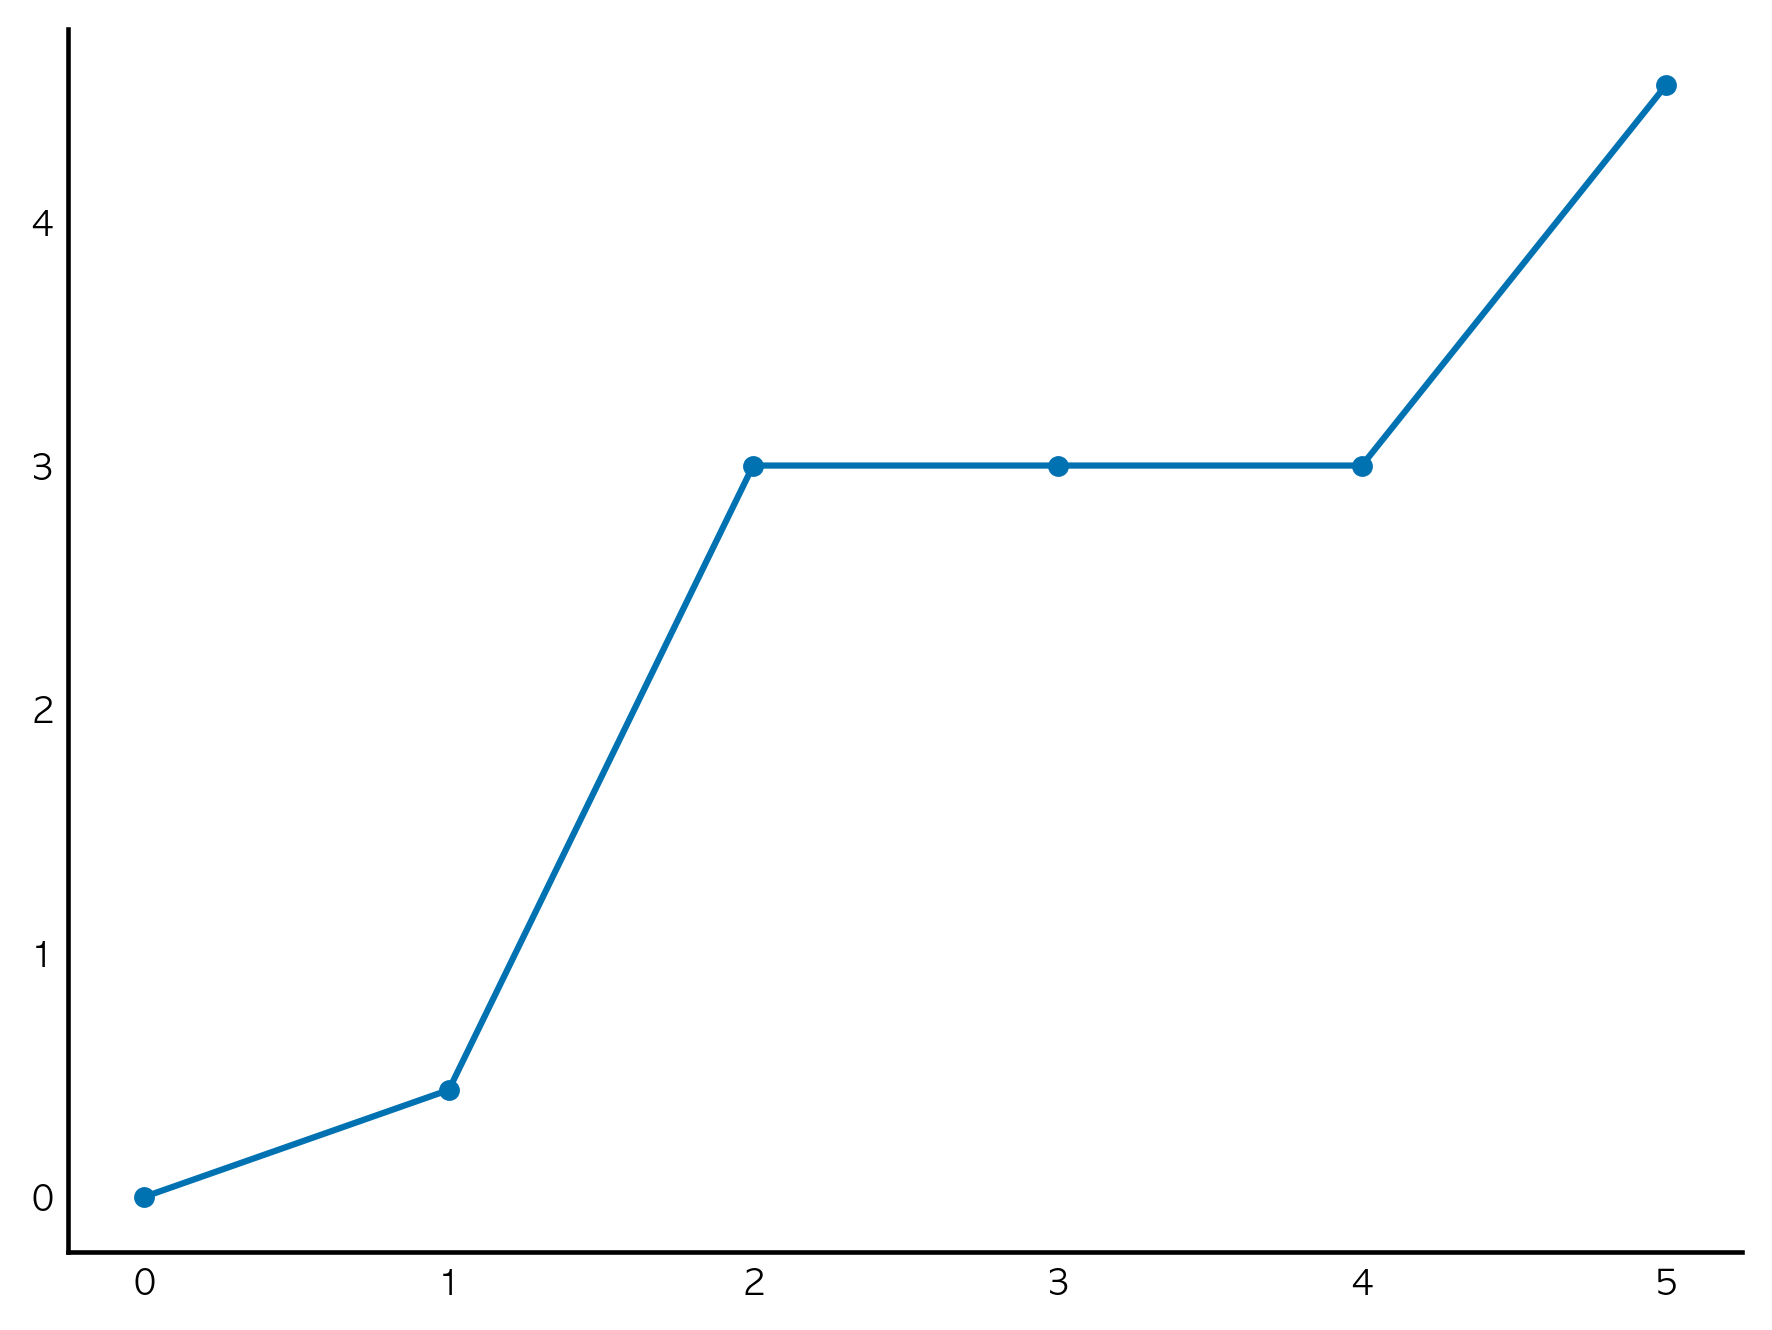

In [15]:
plt.plot(np.sort(val), linestyle='-', marker='o')

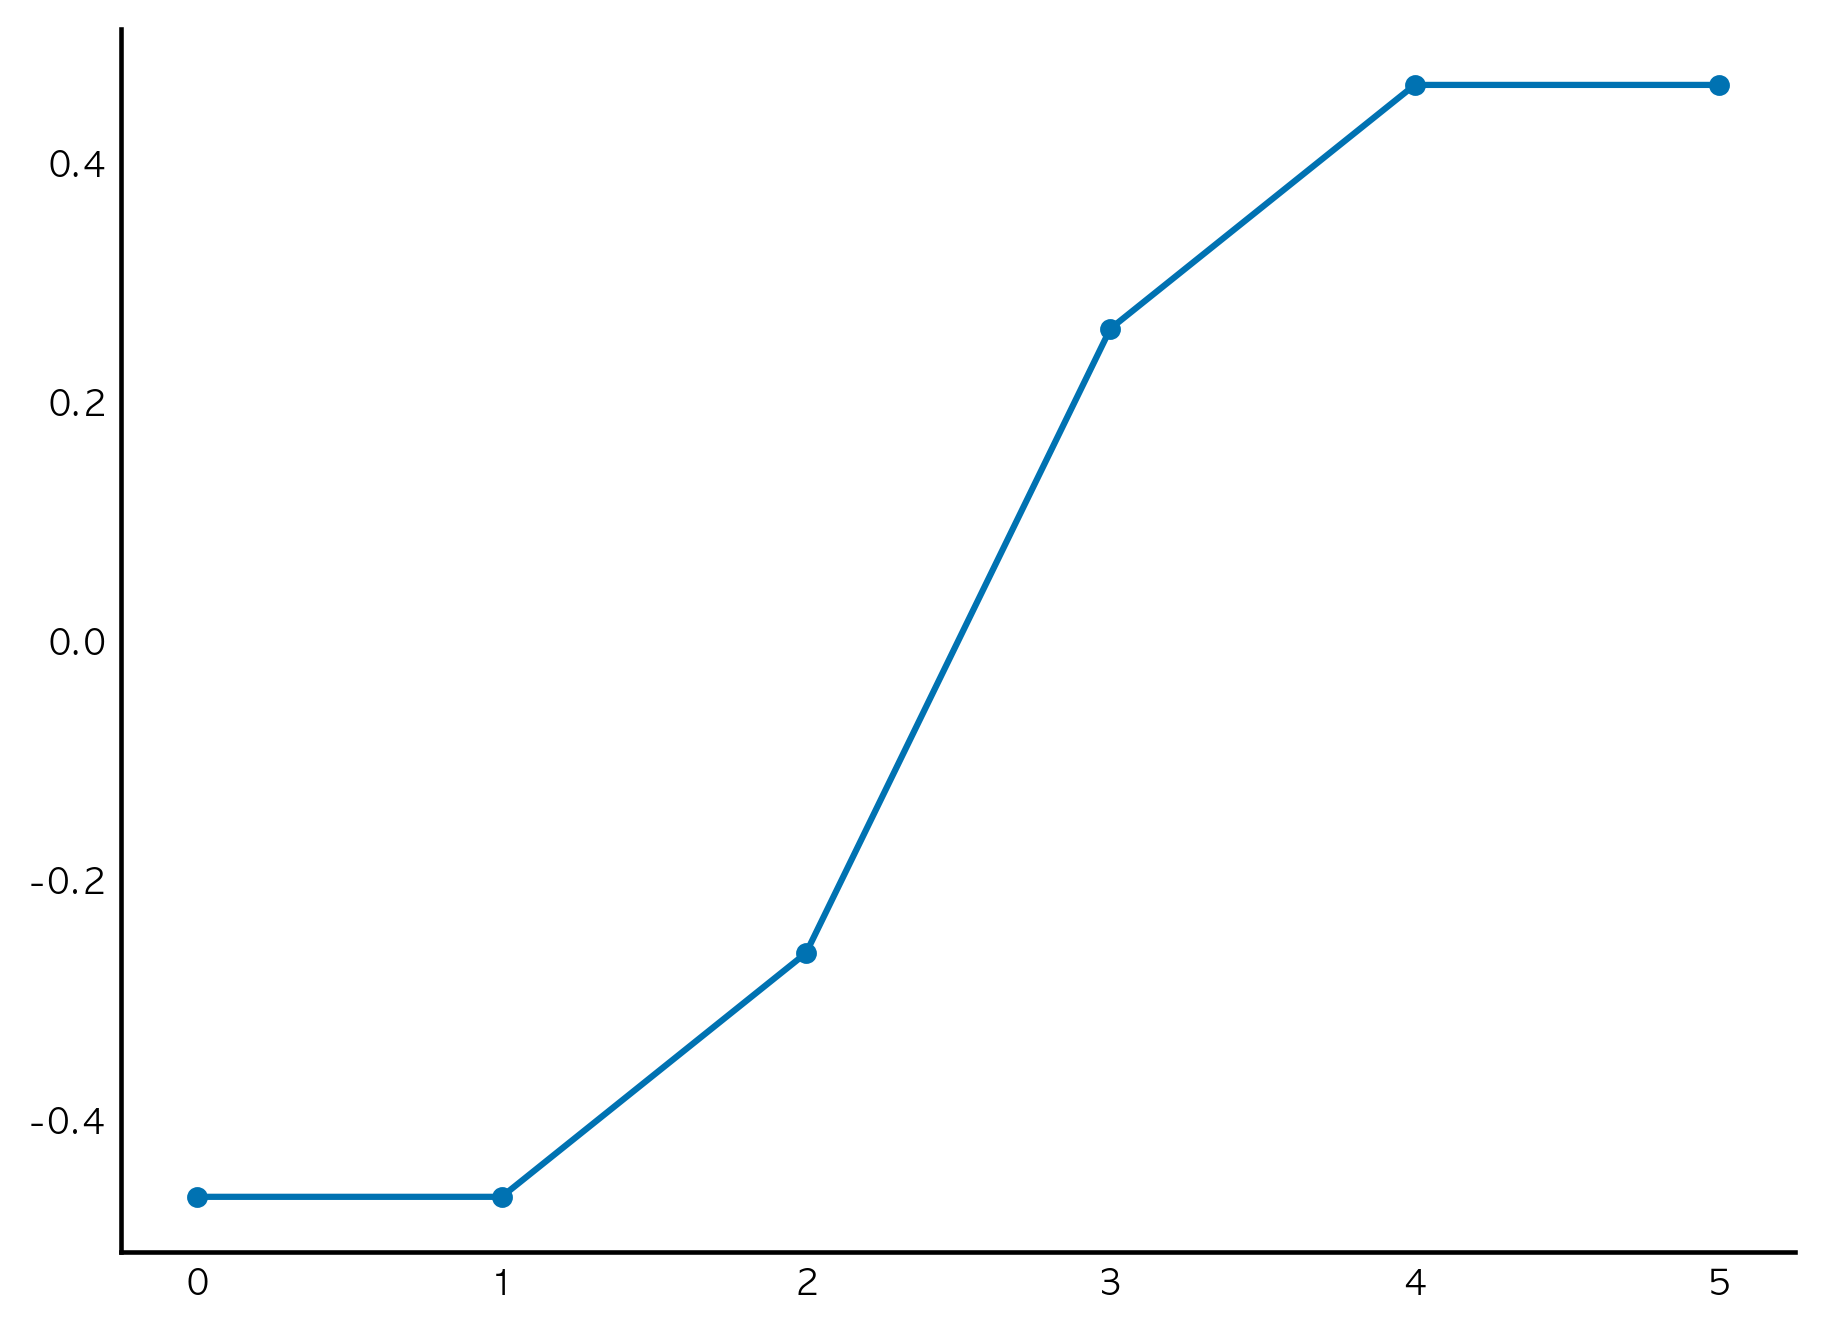

In [16]:
f = Vec[:, np.argsort(val)[1]]
plt.plot(f, linestyle='-', marker='o');

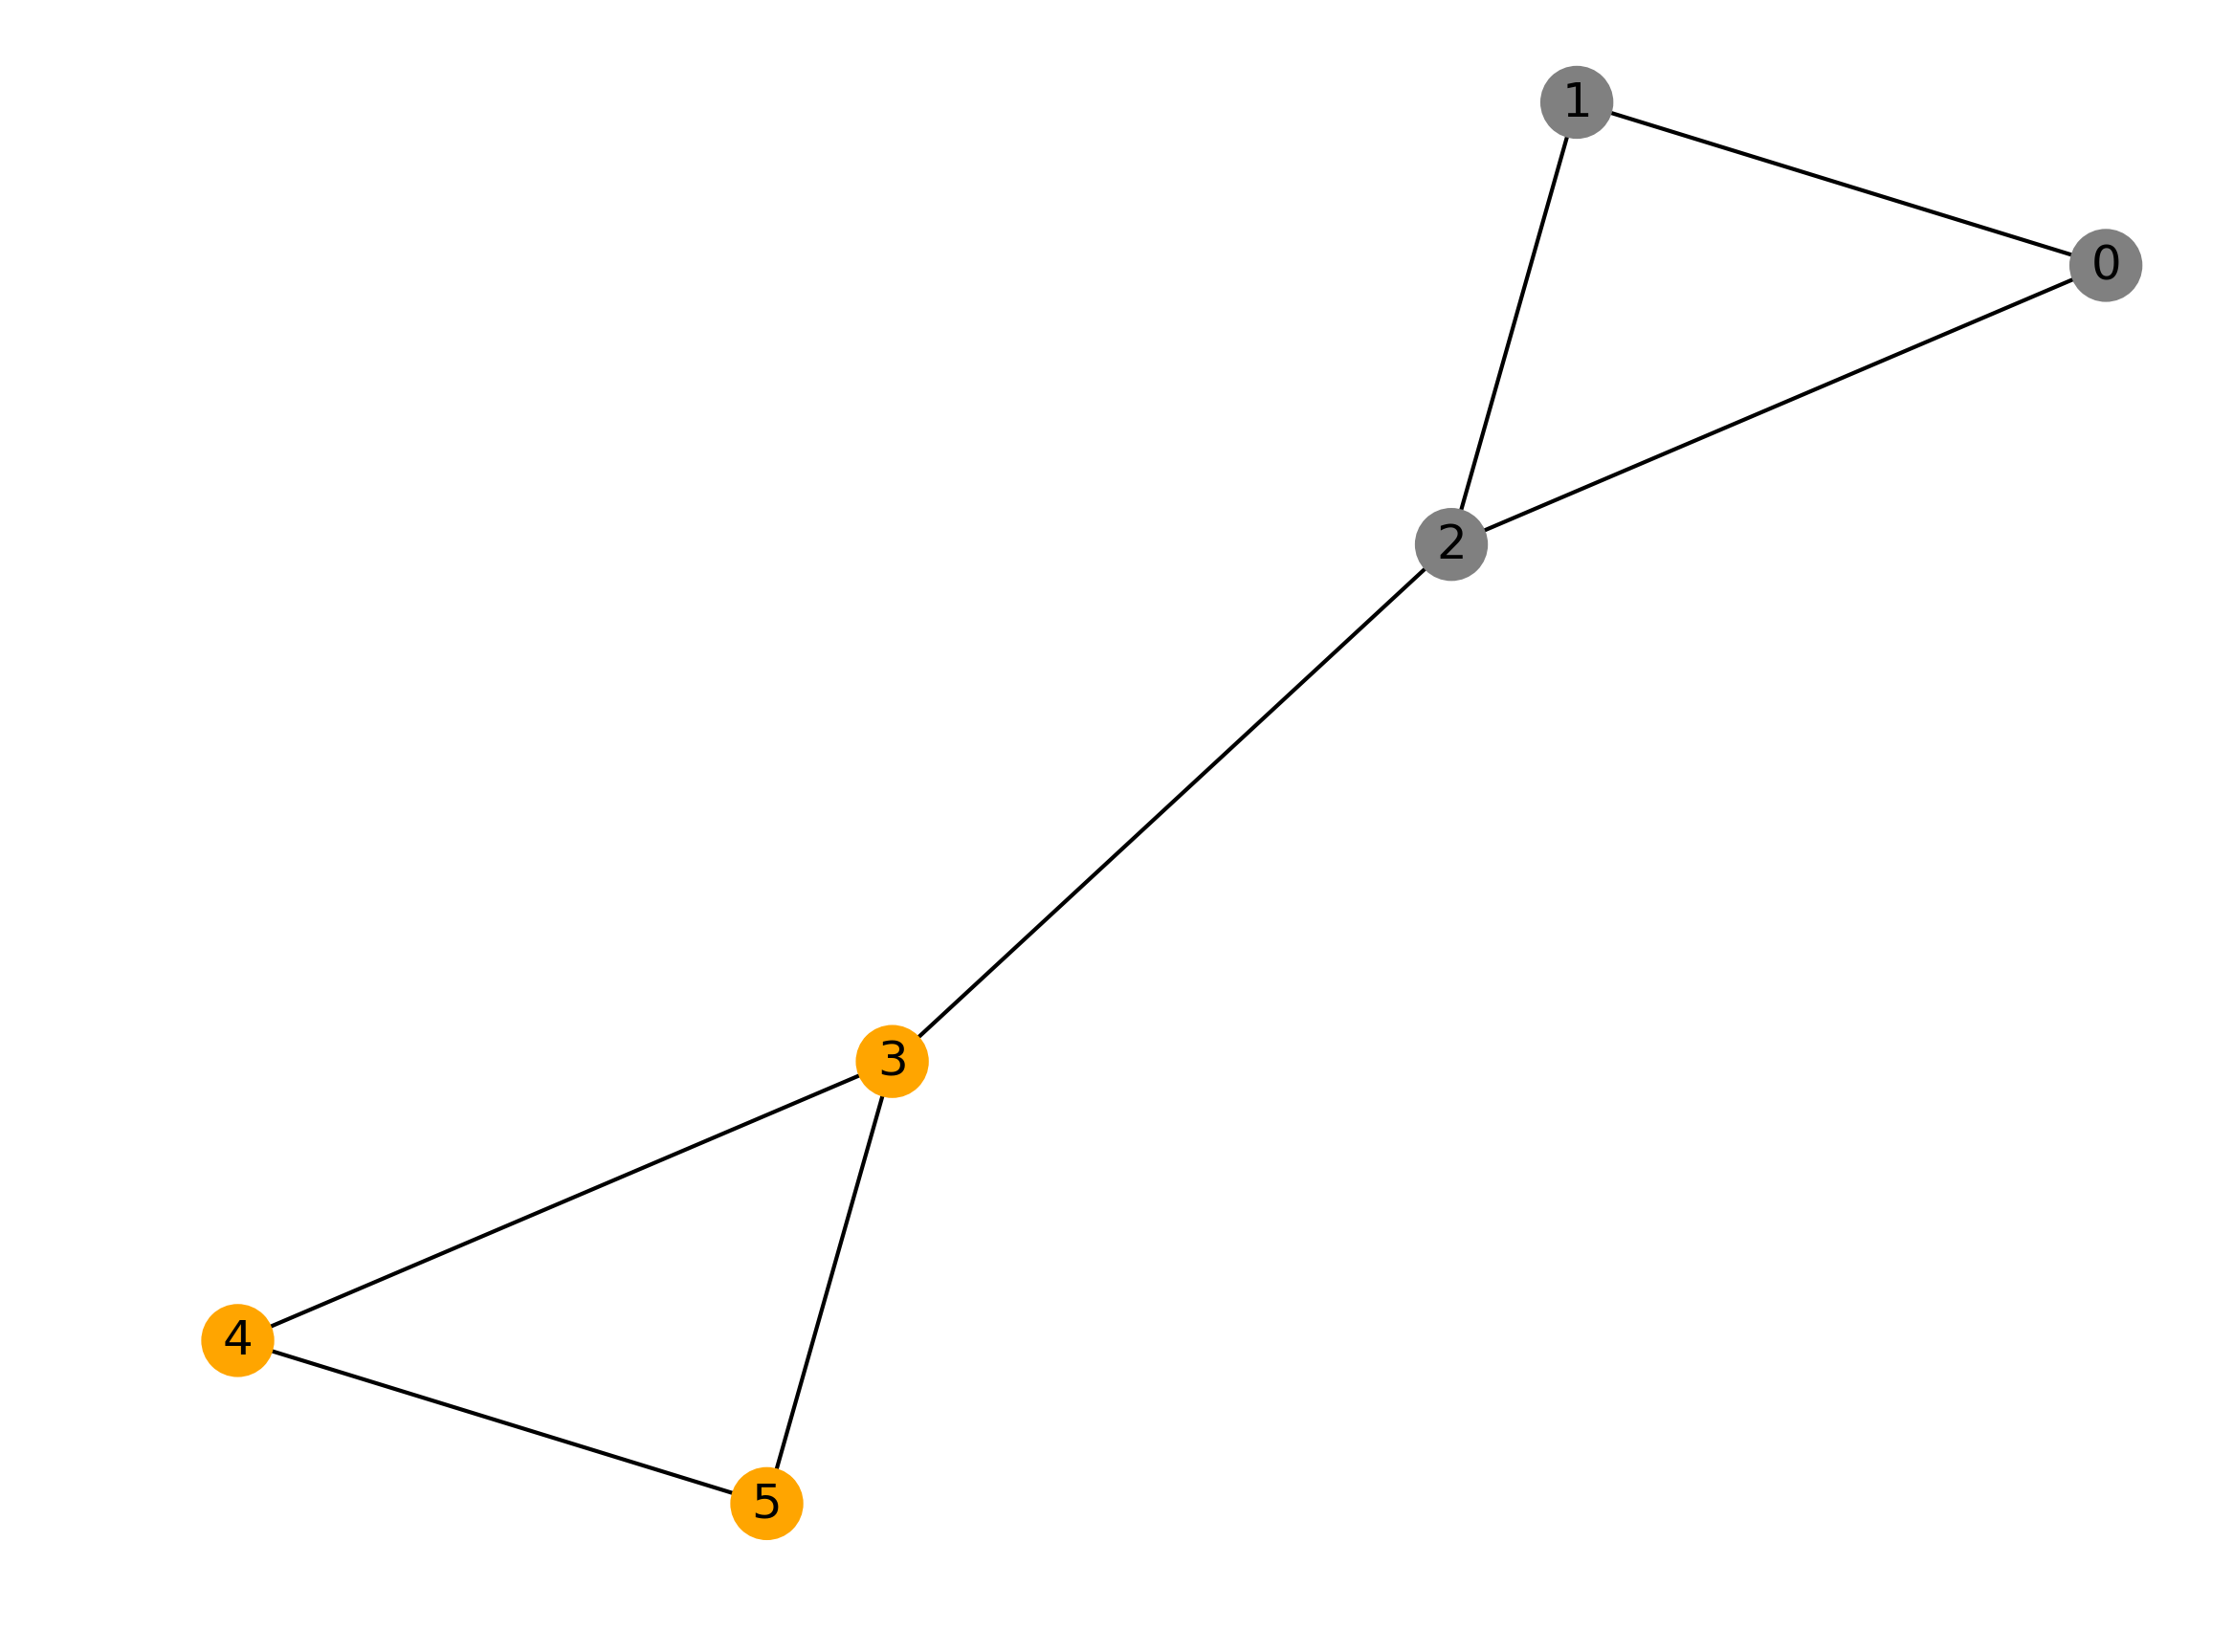

In [17]:
colors = ['orange' if eigv > 0 else 'gray' for eigv in f]
nx.draw(g, pos=layout, with_labels=True, node_color=colors)

## 6.3 뇌 데이터와 라플라시안

In [23]:
import numpy as np

Chem = np.load('data/chem-network.npy')
Gap = np.load('data/gap-network.npy')
neuron_ids = np.load('data/neurons.npy')
neuron_types = np.load('data/neuron-types.npy')

A = Chem + Gap
C = (A + A.T) / 2
degrees = np.sum(C, axis=0)
D = np.diag(degrees)

L = D - C

In [29]:
from scipy import linalg

b = np.sum(C * np.sign(A - A.T), axis=1)
z = linalg.pinv(L) @ b

Dinv2 = np.diag(1 / np.sqrt(degrees))
Q = Dinv2 @ L @ Dinv2

val, Vec = linalg.eig(Q)

smallest_first = np.argsort(val)
val = val[smallest_first]
Vec = Vec[:, smallest_first]

x = Dinv2 @ Vec[:, 1]

vc2_index = np.argwhere(neuron_ids == 'VC02')
if x[vc2_index] < 0:
    x = -x

In [34]:
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection


def plot_connectome(x_coords, y_coords, conn_matrix, *,
                    labels=(), types=None, type_names=('',),
                    xlabel='', ylabel=''):
    """점을 선으로 연결하여, 신경세포 그래프를 그린다.

    신경세포는 다른 유형(최대 6가지 색상)을 가질 수 있다.

    매개변수
    ----------
    x_coords, y_coords : 부동소수점 배열, 모양 (N,)
        신경세포의 x 좌표와 y 좌표
    conn_matrix : 배열 또는 부동소수점 희소행렬, 모양 (N, N)
        노드 i와 노드 j가 연결된 경우, (i, j) 항목이 0이 아닌 연결행렬
    labels : 문자열 배열, 모양 (N,), 선택적 매개변수
        노드 이름
    types : 정수 배열, 모양 (N,), 선택적 매개변수
        노드 유형 (예 : 감각신경세포, 사이신경세포)
    type_names : 문자열 배열, 선택적 매개변수
        유형 이름 
        예를 들어, 0은 감각신경세포를 말한다.
        type_names[0]은 “감각신경세포”다.
    xlabel, ylabel : 문자열, 선택적 매개변수
        축 레이블
    """

    if types is None:
        types = np.zeros(x_coords.shape, dtype=int)
    ntypes = len(np.unique(types))
    colors = plt.rcParams['axes.prop_cycle'][:ntypes].by_key()['color']
    cmap = ListedColormap(colors)

    fig, ax = plt.subplots()

    # 신경세포의 위치를 그린다.
    for neuron_type in range(ntypes):
        plotting = (types == neuron_type)
        pts = ax.scatter(x_coords[plotting], y_coords[plotting],
                         c=cmap(neuron_type), s=4, zorder=1)
        pts.set_label(type_names[neuron_type])

    # 텍스트 레이블을 추가한다.
    for x, y, label in zip(x_coords, y_coords, labels):
        ax.text(x, y, '   ' + label,
                verticalalignment='center', fontsize=3, zorder=2)

    # 에지를 그린다.
    pre, post = np.nonzero(conn_matrix)
    links = np.array([[x_coords[pre], x_coords[post]],
                      [y_coords[pre], y_coords[post]]]).T
    ax.add_collection(LineCollection(links, color='lightgray',
                                     lw=0.3, alpha=0.5, zorder=0))

    ax.legend(scatterpoints=3, fontsize=6)

    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)

    plt.show()

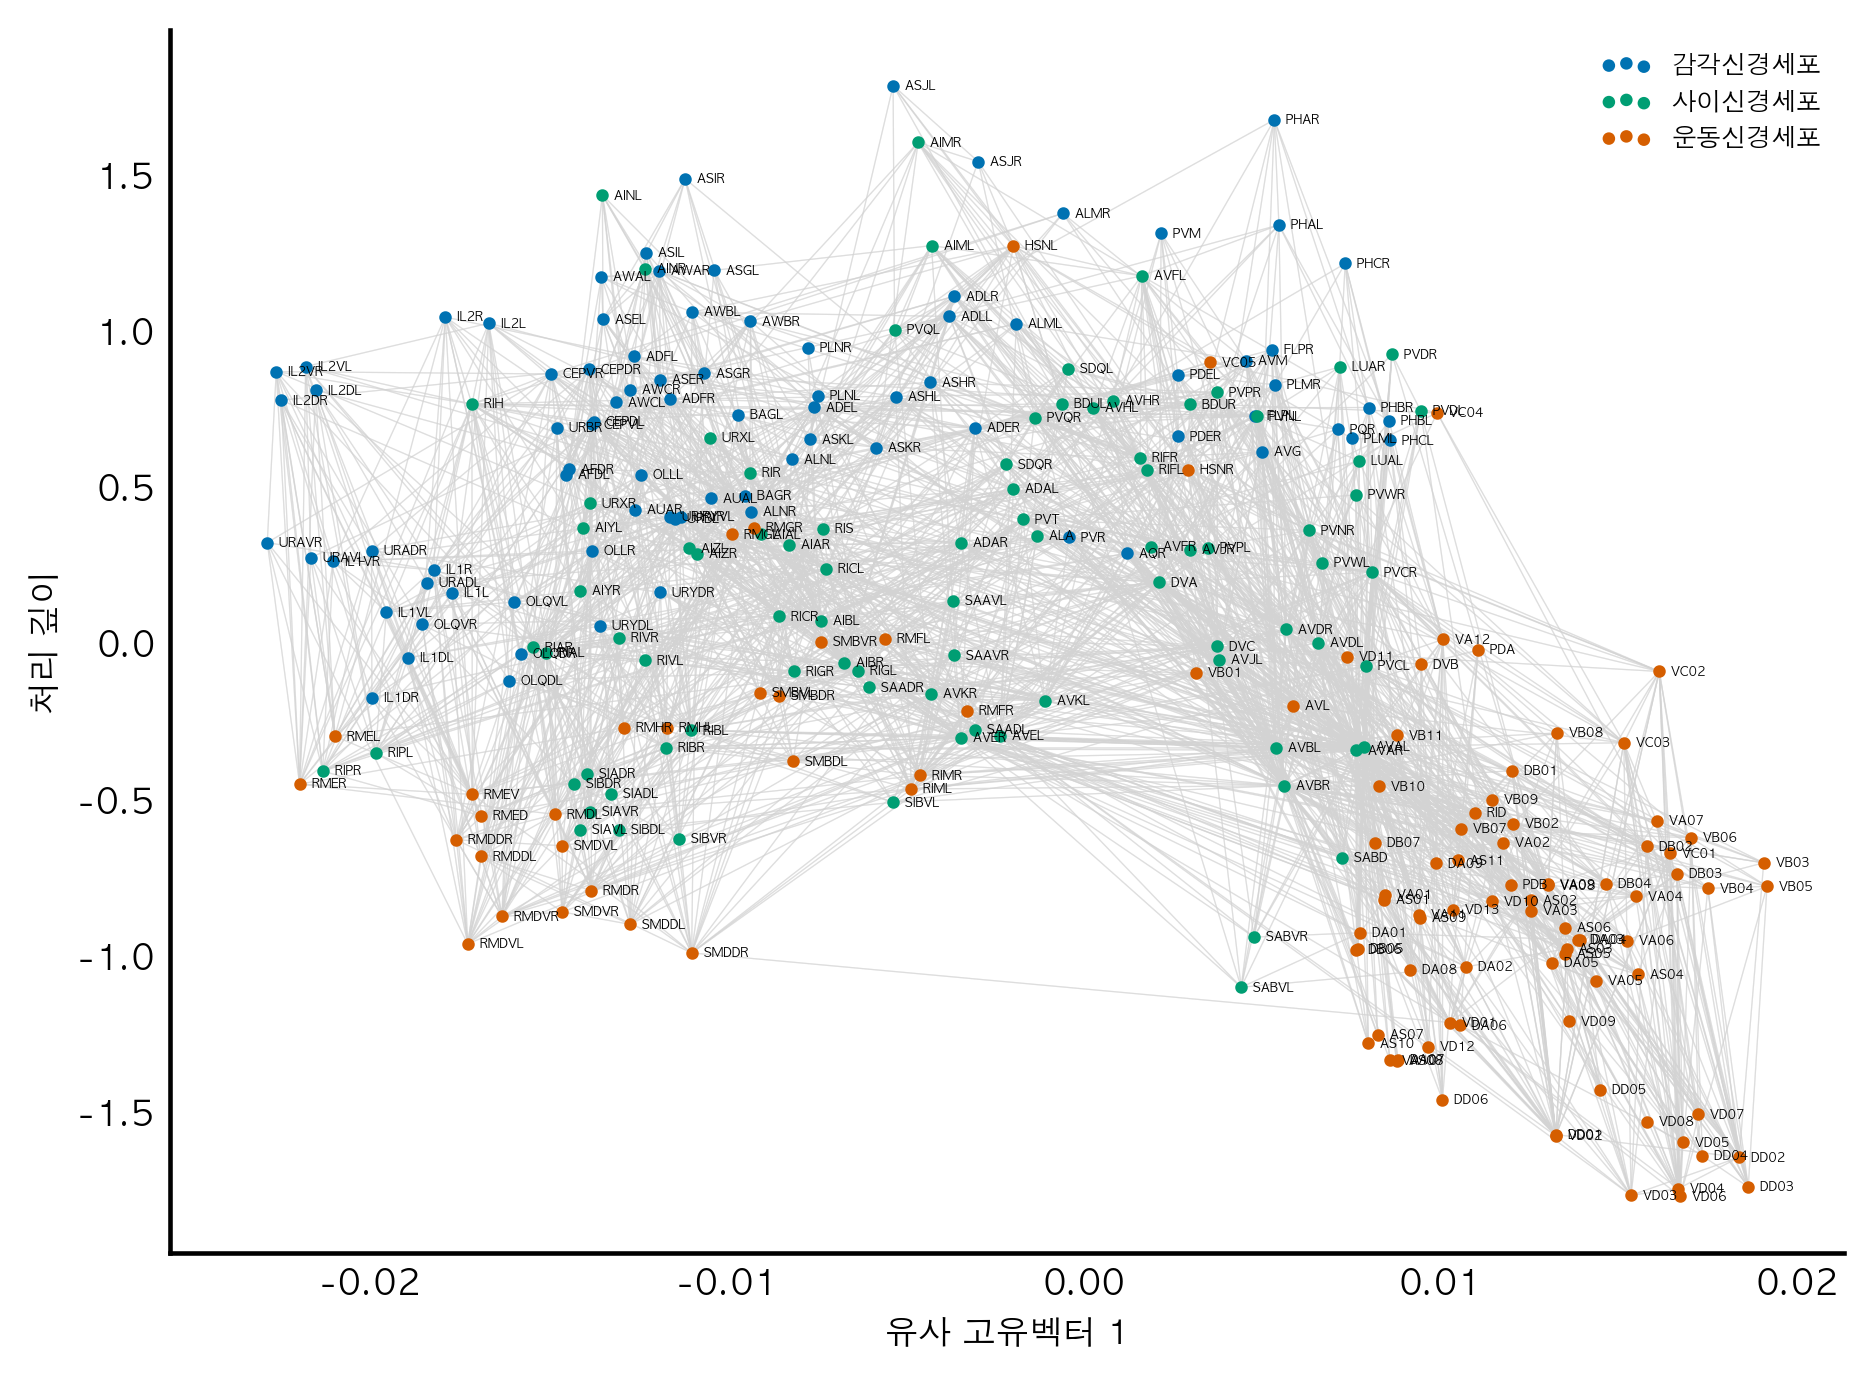

In [35]:
plot_connectome(x, z, C, labels=neuron_ids, types=neuron_types,
                type_names=['감각신경세포', '사이신경세포', '운동신경세포'],
                xlabel='유사 고유벡터 1', ylabel='처리 깊이')

### 6.3.1 연습문제 : 유사도 보기

### 6.3.2 도전 과제 : 희소행렬과 선형대수학

## 6.4 페이지랭크 알고리즘 : 평판과 중요도를 위한 선형대수학

In [39]:
import networkx as nx

stmarks = nx.read_gml('data/stmarks.gml')
species = np.array(stmarks.nodes())  # 다중인덱싱을 위한 배열
Adj = nx.to_scipy_sparse_matrix(stmarks, dtype=np.float64)

n = len(species)

np.seterr(divide='ignore')  # 0으로 나눠서 생기는 오류는 무시한다.

from scipy import sparse

degrees = np.ravel(Adj.sum(axis=1))
Deginv = sparse.diags(1 / degrees).tocsr()

Trans = (Deginv @ Adj).T

In [40]:
from scipy.sparse.linalg import spsolve

damping = 0.85
beta = 1 - damping

I = sparse.eye(n, format='csc')  # 변수 Trans와 동일한 희소행렬 형식

pagerank = spsolve(I - damping * Trans, np.full(n, beta / n))

In [41]:
def pagerank_plot(in_degrees, pageranks, names, *,
                  annotations=[], **figkwargs):
    """수동으로 선택한 노드 이름과 진입차수에 대한 노드 페이지랭크 그래프를 그린다."""

    fig, ax = plt.subplots(**figkwargs)
    ax.scatter(in_degrees, pageranks, c=[0.835, 0.369, 0], lw=0)
    for name, indeg, pr in zip(names, in_degrees, pageranks):
        if name in annotations:
            text = ax.text(indeg + 0.1, pr, name)

    ax.set_ylim(0, np.max(pageranks) * 1.1)
    ax.set_xlim(-1, np.max(in_degrees) * 1.1)
    ax.set_ylabel('페이지랭크')
    ax.set_xlabel('진입차수')

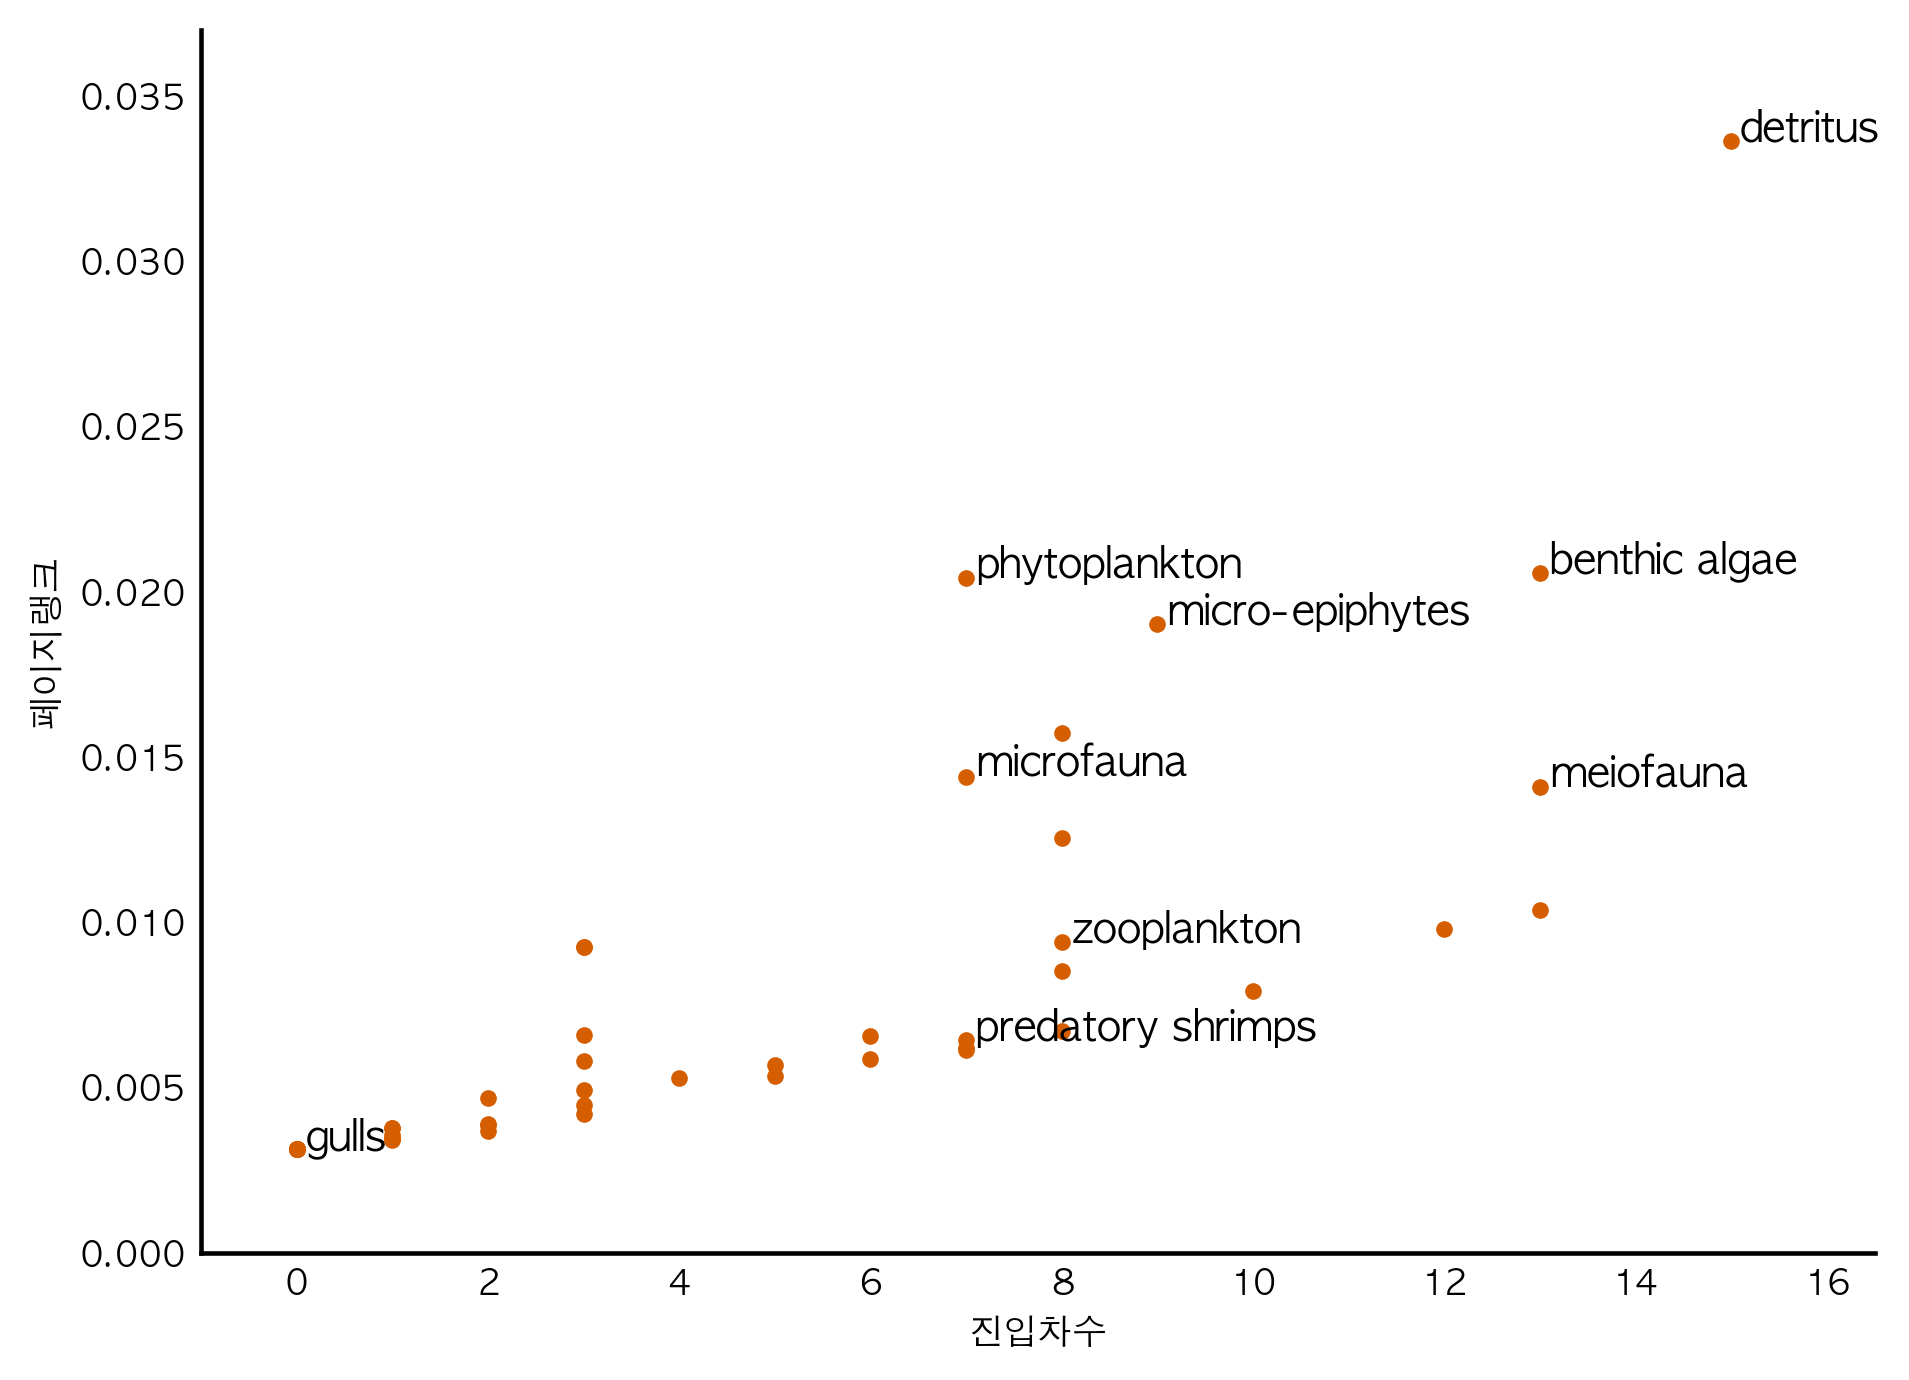

In [43]:
interesting = ['detritus', 'phytoplankton', 'benthic algae', 'micro-epiphytes',
               'microfauna', 'zooplankton', 'predatory shrimps', 'meiofauna',
               'gulls']
in_degrees = np.ravel(Adj.sum(axis=0))
pagerank_plot(in_degrees, pagerank, species, annotations=interesting)

In [44]:
def power(Trans, damping=0.85, max_iter=10**5):
    n = Trans.shape[0]
    r0 = np.full(n, 1/n)
    r = r0
    for _iter_num in range(max_iter):
        rnext = damping * Trans @ r + (1 - damping) / n
        if np.allclose(rnext, r):
            break
        r = rnext
    return r